# GENERATIVE ADVERSARIAL NETWORKS TUTORIAL

Óscar G. Hinde.<br>
Universidad Carlos III de Madrid<br>
oghinde@tsc.uc3m.es<br>        

## Introduction

Generative Adversarial Networks (GANs) are one of the three most popular approaches to generative modeling, together with *Variational Autoencoders* (VAEs) and *Fully Visible Belief Networks* (FVBNs). [They were introduced in 2014](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) at NeurIPS by [Ian Goodfellow](https://ai.google/research/people/105214) et al. 

The reason why GANs have become so popular is because they have provided a relatively simple framework to produce quite capable generative models.

In this tutorial we will use PyTorch to code a simple GAN that can generate realistic artificial images similar to the ones contained in the MNIST handwritten digit database.

*DISCLAIMER*: there are many tutorials on GANs out there and they are all quite similar. Indeed, this tutorial borrows some ideas from other tutorials. The reason I wrote it is because I wanted to learn about GANs myself, and I honestly think that the best way to learn about anything is to try to teach it to someone else. The reason I used PyTorch is similar: I had never used PyTorch before and I thought this would be a good opportunity to kill two birds with one stone. I'm not claiming this tutorial is better or worse than anyone else's!

### Prerequisites

- **Prior knowledge:** decent foundations on Machine Learning and, in particular, Neural Networks are expected (this includes probability theory, algebra and some calculus). You also need to be reasonably comfortable with Python. 

- **Harware requirements:** a computer (duh). We're not going to worry about GPUs in this tutorial.

- **Software requirements:** Python 3, PyTorch, Numpy and Matplotlib. If you work with Anaconda and have PyTorch installed you should be golden.

### GANs in a nutshell

The basic idea behind GANs is that there are two models playing a game against each other. The first model, the *discriminator*, can be thought of as a policeman who specializes in check forgery detection. The other model, the *generator*, is a counterfeiter that specializes in creating very believable fake checks. The policeman is constantly evaluating checks, some of which are authentic and some are fakes. His job is obviously to be able to identify the fake documents. On the other hand, the counterfeiter needs to get better and better at his job of creating fake checks. In this movie the counterfeiter is the good guy and the policeman is the villain.

### Some formalisms

<img src="flow.jpeg" alt="Drawing" style="width: 600px;"/>

Both models, the discriminator and the generator, must be differentiable both with respect to their outputs and their parameters. In theory, one can use any model that meets this requirement, but in practice GANs are almost exclusively implemented using Deep Neural Networks (DNNs).

From Ian Goodfellow's original paper:

*The adversarial modeling framework is most straightforward to apply when the models are both
multilayer perceptrons. To learn the generator’s distribution $p_g$ over data $x$, we define a prior on input noise variables $p_z(z)$, then represent a mapping to data space as $G(z | \theta_g)$, where $G$ is a differentiable function represented by a multilayer perceptron with parameters $\theta_g$. We also define a second multilayer perceptron $D(x | \theta_d)$ that outputs a single scalar. $D(x)$ represents the probability that $x$ came from the data rather than $p_g$. We train $D$ to maximize the probability of assigning the correct label to both training examples and samples from $G$. We simultaneously train $G$ to minimize
$\log(1 − D(G(z)))$. In other words, $D$ and $G$ play the following two-player minimax game with value function $V(G, D)$:*

$$
\min_G \max_D V(G, D) = \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[\log (1 - D(G(z))]
$$

In simpler terms, $D$ is trying to correctly distiguish real images from fake ones, in which case $V(G, D) = 0$. On the other hand, $G$ is trying to trick $D$ into thinking that $G(z)$ is in fact a real image. In achieving this it would force $V(G, D)$ to go to $-\infty$.

From a game-theoretical perspective, if both models have sufficient capacity (i.e. they are universal function approximators and are given enough time to train) the Nash equilibrium of this game is reached when $D(x) = D(G(z)) = \frac{1}{2}$, meaning that the discriminator is no longer able to distinguish real samples from generated samples.

By design, GANs have many advantages compared to other generative models:
- They can generate samples in paralel (unlike FVBNs).
- The design of the generator function has very few restrictions (unlike Boltzman machines or non-linear ICA).
- No Markov Chains are needed (again, an advantage relative to Boltzman machines).
- No variational bound is needed and many specific model families usable by GANs are already known to be universal approximators, so GANs are by definition asymptotically consistent (unlike many examples of VAEs).

But perhaps more importantly:
- GANs are subjectively regarded as producing better samples than other methods.

However, GANs do not come without their own share of disadvantages. From the original paper: *primarily, there is no explicit representation of $p_g(x)$, and $D$ must be synchronized well with $G$ during training (in particular, $G$ must not be trained too much without updating $D$, in order to avoid “the Helvetica scenario” in which $G$ collapses too many values of $z$ to the same value of $x$ to have enough diversity to model $p_{data}$), much as the negative chains of a Boltzmann machine must be kept up to date between learning steps*.

### The Algorithm

The algorithm in pseudocode, as dercribed in Goodfellow's paper, is as follows:

<img src="GAN_algo.png" alt="Drawing" style="width: 650px;"/>

In our example we will use $k = 1$ to minimize computational time. As we shall see, there are a few key differences when applying this algorithm in real life.

## Let's code a GAN

Time to get our hands dirty!

We will encounter some parameters (latent space dimensionality, dropout rate, etc.) whose values will be predifined. These could obviously be validated to obtain better results but that would lie beyond the scope of this tutorial.

Initially we will import all the necessary libraries and modules. We will aslo define a few simple functions that will help us clean up the code.

In [9]:
# Import some stuff
import numpy as np
from matplotlib import pyplot as plt
import time

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

# Define some useful functions
def images_to_vectors(images):
    '''
    Turns a 2d image into a vector.
    '''
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    '''
    Turns a vector into a 2d image.
    '''
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values.
    We will use this to generate samples from the latent space Z.
    '''
    n = Variable(torch.randn(size, 100))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size.
    This will be used as a target vector for the discriminator.
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size.
    This will be used as a target vector for the discriminator.
    '''
    data = Variable(torch.zeros(size, 1))
    return data

We will now import the *MNIST* database from PyTorch's datasets. We normalise the images so that their values have zero mean and lie between -1 and 1.

In [11]:
# Import normalised MNIST dataset
def mnist_data():
    compose = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))
                                 ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
data = mnist_data()

# We need to be able to iterate over the data, so we create a loader
# Batch size of 100 is enough for now
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)

## Model Definition

Here's where things get interesting. Let's start by putting together the elements of our GAN. As we now know, there are two players: the discriminator network and the generator network.

### Discriminator Network

The first step is to create the *discriminator* network, whose purpose is to dertermine whether a given image is real or generated (fake). In this case we will use a very simple setup with three fully connected hidden layers. There are a couple of very important details that make the whole setup work, though: first, the use of leaky rectified linear unit activation functions; second, the application of a dropout regularization strategy. 

The architecture we will use is as follows:

- 784 input dimensions (28 x 28 pixels).
- 1 output dimension (real image or generated image).
- Three fully connected hidden layers using Leaky ReLUs and dropout:
    - *Layer 1*: 
        - IO dimensions: 784 &rarr; 1024
        - Activation: LeakyReLU(0.2) 
        - Dropout(0.3)
    - *Layer 2*: 
        - IO dimensions: 1024 &rarr; 512 
        - Activation: LeakyReLU(0.2)
        - Dropout(0.3)
    - *Layer 3*: 
        - IO dimensions: 512 &rarr; 256
        - Activation: LeakyReLU(0.2)
        - Dropout(0.3)
- One fully connected output layer using a Sigmoid activation function:
    - *Output layer*:
        - IO dimensions: 256 &rarr; 1
        - Activation: Sigmoid


In [12]:
# Create the Discriminator Network class.
class DiscriminatorNet(nn.Module):
    '''
    This is the discriminator network:
        - Three fully connected hidden layers.
        - Leaky ReLu throughout with 0.2 slope.
        - Dropout with p = 0.3
        - Sigmoid output activation.
    '''
    
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        
        n_features = 784 # Flattened input image
        n_out = 1        # Real or fake?
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        
        return x

discriminator = DiscriminatorNet()
print(discriminator)

DiscriminatorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


### Generator Network

Now comes the protagonist of the show: the *generator* network. It's goal is obviously to learn to generate samples (images in this case) that are so good that the discriminator is unable to tell them appart from the real deal. In this example this network is mostly a mirror image of the discriminator network (although is doesn't have to be). A couple of important differences: the input dimension is the dimension of the latent space, $Z$, which in this case we have fixed to 100; also we don't use dropout in this network because we're not interested in a regularization strategy in the generative process (furthermore, the inputs from the latent space $Z$ are already random noise). Finally, the output layer uses a hyperbolic tangent activation function that will give us output values in the required range: $x \in [-1, 1]$.

The architecture we will use is as follows:

- 100 input dimensions (the dimensionality of the latent space).
- 784 output dimensions (28 x 28 pixels).
- Three fully connected hidden layers using Leaky ReLUs:
    - *Layer 1*: 
        - IO dimensions: 100 &rarr; 256
        - Activation: LeakyReLU(0.2)
    - *Layer 2*: 
        - IO dimensions: 256 &rarr; 512 
        - Activation: LeakyReLU(0.2) 
    - *Layer 3*:
        - IO dimensions: 512 &rarr; 1024 
        - Activation: LeakyReLU(0.2)
- One fully connected output layer using a Tanh activation function:
    - *Output layer*: 
        - IO dimensions: 1024 &rarr; 784 
        - Activation: Tanh


In [13]:
# Create the Generator Network class.
class GeneratorNet(nn.Module):
    '''
    This is the generator network:
        - Three fully connected hidden layers.
        - Leaky ReLu throughout with 0.2 slope.
        - No dropout.
        - Tanh output activation.
    '''
    
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

generator = GeneratorNet()
print(generator)

GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)


## Training the Model

We will now deal with the real challenge of GAN models: the training process. This is where we play the *minmax* game between the discriminator and the generator. The idea here is that, with each iteration, the discriminator is trained on both real images from the dataset and fake images produced by the discriminator. The generator is in turn tought to modify its outputs in such a way thet the discriminator finds it harder and harder to distinguish them from the real thing. 

### Loss Function

The loss function we will use is the Binary Cross Entropy Loss (BCE-Loss). Since our discriminator already outputs a sigmoid, we don't need to use the logit version. The BCE-Loss can be described as:

$$
L = \{l_1, ..., l_N\}^{\top}, \quad l_n = -w_n[y_n \cdot \log v_n + (1 - y_n) \cdot \log (1 - v_n)]
$$

Where $w_n$ is a rescaling weight given to the loss of each batch element. In this case we will not be using it so we shall leave it at its default value of 1.

Remember from the *minmax* game that the **discriminator** wants to maximize the following quantity:

$$
\frac{1}{N}\sum^{N}_{n=1}\log D(x_n) + \log(1 - D(G(z_n)))
$$

Since most machine learning frameworks (including PyTorch) implement minimization instead of maximization strategies, we can simply change the sign of the expression above to obtain the desired result. If we replace $v_n = D(x_n$) and $y_n = 1, \,\forall\, n$ in the BCE-Loss definition, we will obtain the loss related to the real images. Conversely if we set $v_n = D(G(z_n))$ and $y_n=0, \,\forall\, n$, we will obtain the loss related to the generated images.

The **generator** in turn wants to minimize the following quantity:

$$
\frac{1}{N}\sum^{N}_{n=1}\log(1 - D(G(z_n)))
$$

However, this strategy will lead to a dead end early in the training process: initially the discriminator will become very good at distinguishing fake images from real ones very quickly, causing the generator's gradients to vanish almost immediately. The trick is to instead maximize for $log(D(G(z_n)))$. This change has no effect on the end-game dynamics. Maximizing this quantity is equivalent to minimizing its negative, so we can set $v_n = D(G(z_n))$ and $y_n=1 \,\forall\,n$ in the BCE-Loss definition to obtain the expression that we need to minimize.

### Optimizer

We will use the Adam algorithm for the optimization phase. This method gives good results and is generally more efficient than classic Stochastic Gradient Descent (SGD) in terms of both compute cycles and memory. Interestingly, [there are a few recent studies](http://papers.nips.cc/paper/7003-the-marginal-value-of-adaptive-gradient-methods-in-machine-learning.pdf) suggesting that the use of adaptive optimization algorithms such as Adam offer poor generalization characteristics when comparred with classic SGD. This is, however, not relevant to this tutorial and we can definitely use the computational advantages of Adam if we're running this on puny, GPU-less laptops. 

We need to define two optimizers, one for each network, with identical learning rates, $lr = 0.0002$.

In [14]:
# We will use the Binary Cross Entropy Loss function.
loss = nn.BCELoss()

# We need two Adam optimizers, one for each network.
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

### Training functions

The following steps are performed for each epoch and each batch. We're going to break down the training loop a bit for the sake of readability. 

The first step is to generate a training set of real and fake data by sampling a batch of images from the real dataset and generating a batch of fake images by feeding noise through the generator network. It's important to fix ([detach](https://discuss.pytorch.org/t/detach-no-grad-and-requires-grad/16915/2)) the generator's parameters while we focus on the discriminator's training. This produces a clearer gradient.

Next, we will define a function that goes through the **discriminator training process**. This is quite a standard procedure:
1. We first reset the gradients in the optimizer.
2. We then feed forward the training data set, compute the loss and backpropagate.
3. We finally perform an optimization step **with the optimizer dedicated to the discriminator network**.

In [15]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Concatenate real and fake data and generate labels.
    train_data = torch.cat((real_data, fake_data), 0)
    train_labels = torch.cat((ones_target(N), zeros_target(N)), 0)
    
    # Perform forward pass, calculate error and backpropagate.
    prediction = discriminator.forward(train_data)
    error = loss(prediction, train_labels)
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error

The **generator training process** is somewhat different, and the key to the whole GAN idea. After generating a *new batch of fake images* (this time with the generator parameters attached, so they can be updated) :
1. We first reset the gradients in the optimizer.
2. We then feed the new batch of fake data to the discriminator, compute the loss and backpropagate. The caveat is that in this case *we're telling the discriminator that the images are real when, in fact, they're not*.
3. We finally perform an optimization step **with the optimizer dedicated to the generator network**.

To fully understand how PyTorch handles this it is essential to understand how [autograd](https://towardsdatascience.com/getting-started-with-pytorch-part-1-understanding-how-automatic-differentiation-works-5008282073ec) works. The important lesson is that the generator is learning what direction it must move in order to trick the discriminator into confusing a fake image with a real one. 

In [16]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()
    
    # Perform forward pass on the discriminator with fake data.
    prediction = discriminator.forward(fake_data)
    
    # Calculate error and backpropagate
    # Here's the key: you're calculating loss on flipped labels!
    error = loss(prediction, ones_target(N))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

### The training loop

Once we have the two training functions defined, we can finally run through the training loop for a sufficient number of epochs and (hopefully) witness how our GAN learns to draw realistic looking hand-written digits.


STATUS:
  - Epoch: 0
  - Batch: 0

Generator Samples


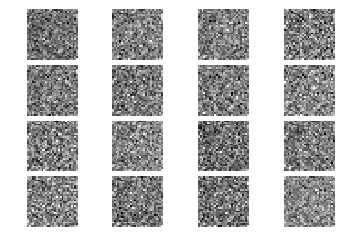


STATUS:
  - Epoch: 0
  - Batch: 100

Generator Samples


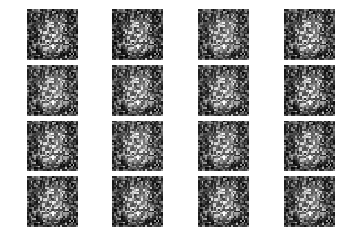


STATUS:
  - Epoch: 0
  - Batch: 200

Generator Samples


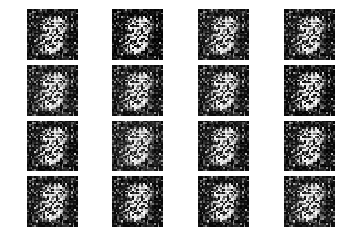

KeyboardInterrupt: 

In [17]:
num_test_samples = 16
test_noise = noise(num_test_samples) # to visualize some test images

# Total number of epochs to train
num_epochs = 200

start = time.time()
for epoch in range(num_epochs):
    start_epoch = time.time()
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)

        # 1. TRAIN DISCRIMINATOR
        
        # Grab real data
        real_data = Variable(images_to_vectors(real_batch))
        
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()

        # Discriminator training function
        d_error = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. TRAIN GENERATOR
        
        # Generate fake data
        fake_data = generator(noise(N))
        
        # Generator training function
        g_error = train_generator(g_optimizer, fake_data)
        
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            
            print('\nSTATUS:')
            print('  - Epoch: {}'.format(epoch))
            print('  - Batch: {}'.format(n_batch))
            print('\nGenerator Samples')
            
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data

            fig = plt.figure()
            fig.subplots_adjust(hspace=0.1, wspace=0.1)
            for i in range(1, 17):
                img = np.squeeze(test_images[i-1])
                ax = fig.add_subplot(4, 4, i)
                ax.imshow(img, cmap='gray')
                ax.axis('off')
            plt.show()
    end_epoch = time.time()
    print('Epoch time = {:.2f} seconds'.format((end_epoch - start_epoch)))

end = time.time()

print('\nDONE!')
print('Elapsed time = {:.2f} hours'.format((end - start)/(60**2)))

# Generate and view some final samples
test_images = vectors_to_images(generator(test_noise))
test_images = test_images.data

fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(1, 17):
    img = np.squeeze(test_images[i-1])
    ax = fig.add_subplot(4, 4, i)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()
fig.savefig('final_samples.png', format='png')